                   **   TASK 3**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import numpy as np

In [ ]:
customers_df = pd.read_csv('/content/Customers.csv')
products_df = pd.read_csv('/content/Products.csv')
transactions_df = pd.read_csv('/content/Transactions.csv')

In [ ]:
print("Customers Dataset:")
print(customers_df.head())
print("\nProducts Dataset:")
print(products_df.head())
print("\nTransactions Dataset:")
print(transactions_df.head())

Customers Dataset:
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15

Products Dataset:
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31

Transactions Dataset:
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166   

In [ ]:
print("\nCustomers Data Info:")
print(customers_df.info())
print("\nProducts Data Info:")
print(products_df.info())
print("\nTransactions Data Info:")
print(transactions_df.info())


Customers Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None

Products Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None

Transactions Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column   

In [ ]:
print("\nMissing Values in Customers:")
print(customers_df.isnull().sum())
print("\nMissing Values in Products:")
print(products_df.isnull().sum())
print("\nMissing Values in Transactions:")
print(transactions_df.isnull().sum())


Missing Values in Customers:
CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64

Missing Values in Products:
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64

Missing Values in Transactions:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [ ]:
transactions_merged = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')

In [ ]:
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
transactions_over_time = transactions_df.groupby(transactions_df['TransactionDate'].dt.to_period('M')).size()

In [ ]:
customer_product_matrix = transactions_merged.pivot_table(
    index='CustomerID',
    columns='ProductID',
    values='TotalValue',
    aggfunc='sum',
    fill_value=0
)

In [ ]:
scaler = StandardScaler()
customer_product_normalized = scaler.fit_transform(customer_product_matrix)

In [ ]:
similarity_matrix = cosine_similarity(customer_product_normalized)

In [ ]:
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=customer_product_matrix.index,
    columns=customer_product_matrix.index
)


In [ ]:
def get_top_3_lookalikes(customer_id):
    if customer_id not in similarity_df.index:
        return []
    similar_customers = similarity_df[customer_id].sort_values(ascending=False)[1:4]
    return [(cust_id, score) for cust_id, score in similar_customers.items()]

In [ ]:
lookalike_results = {
    customer_id: get_top_3_lookalikes(customer_id)
    for customer_id in customers_df['CustomerID'][:20]
}

In [ ]:
transactions_merged['Price'] = transactions_merged['TotalValue'] / transactions_merged['Quantity']


In [ ]:
customer_features = transactions_merged.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'Price': 'mean'
}).reset_index()

In [ ]:
feature_scaler = StandardScaler()
customer_features_scaled = feature_scaler.fit_transform(customer_features[['TotalValue', 'Quantity', 'Price']])

In [ ]:
num_clusters = 5  # You can tune this number
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(customer_features_scaled)

KMeans(n_clusters=5, random_state=42)

In [ ]:
customer_features['Cluster'] = kmeans.labels_

In [ ]:
db_index = davies_bouldin_score(customer_features_scaled, kmeans.labels_)
print(f"Davies-Bouldin Index: {db_index}")


Davies-Bouldin Index: 0.9467058109377833


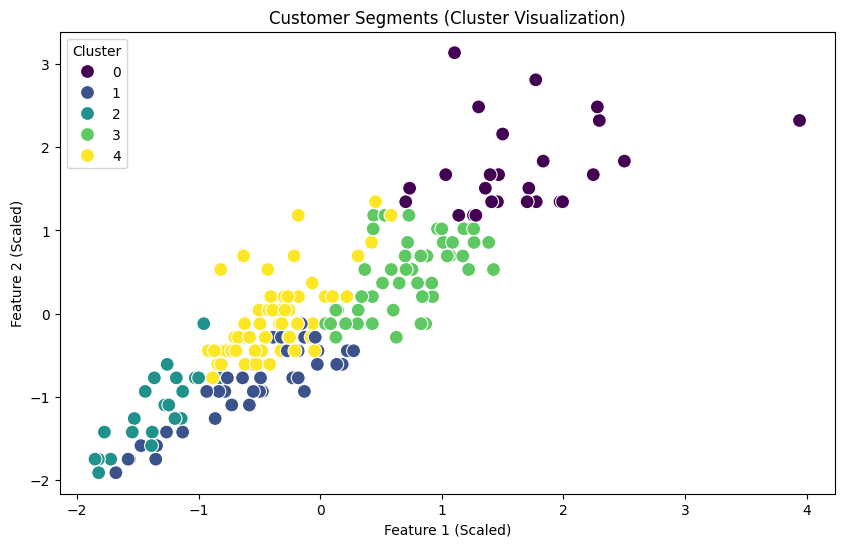

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=customer_features_scaled[:, 0],
    y=customer_features_scaled[:, 1],
    hue=customer_features['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Segments (Cluster Visualization)')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.legend(title='Cluster')
plt.show()

In [ ]:
customer_features.to_csv('Customer_Segments.csv', index=False)
print("Customer segmentation results saved to 'Customer_Segments.csv'.")

Customer segmentation results saved to 'Customer_Segments.csv'.
